In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

"""
Output layer projects hidden states back to vocabulary logits
"""

class OutputLayer(nn.Module):
    def __init__(self, d_model, vocab_size):
        super().__init__()
        self.linear = nn.Linear(d_model, vocab_size)
        
    def forward(self, x):
        """
        x: [batch, seq_len, d_model]
        returns: [batch, seq_len, vocab_size]
        """
        return self.linear(x)

# Test
d_model = 512
vocab_size = 10000

output_layer = OutputLayer(d_model, vocab_size)
x = torch.randn(2, 10, d_model)
logits = output_layer(x)

print(f"Input: {x.shape}")
print(f"Logits: {logits.shape}")
print("✅ Output layer working")

Input: torch.Size([2, 10, 512])
Logits: torch.Size([2, 10, 10000])
✅ Output layer working


In [2]:
# Import components from previous days
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def split_heads(self, x):
        batch, seq_len, d_model = x.size()
        x = x.view(batch, seq_len, self.num_heads, self.d_k)
        return x.transpose(1, 2)
    
    def combine_heads(self, x):
        batch, heads, seq_len, d_k = x.size()
        x = x.transpose(1, 2)
        return x.contiguous().view(batch, seq_len, self.d_model)
    
    def forward(self, x, mask=None):
        Q = self.split_heads(self.W_q(x))
        K = self.split_heads(self.W_k(x))
        V = self.split_heads(self.W_v(x))
        
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        output = self.combine_heads(output)
        return self.W_o(output), attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(d_ff, d_model)
        
    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.dropout(x)
        return self.linear2(x)

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        
        self.ff = FeedForward(d_model, d_ff, dropout)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(dropout)
        
    def forward(self, x, mask=None):
        attn_output, attn_weights = self.attention(x, mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        
        ff_output = self.ff(x)
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        
        return x, attn_weights

import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]

class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
        
    def forward(self, x):
        return self.embedding(x) * math.sqrt(self.d_model)

# Complete Transformer
class SimpleTransformer(nn.Module):
    """
    Complete transformer for next-token prediction (GPT-style)
    """
    def __init__(
        self,
        vocab_size,
        d_model=512,
        num_layers=6,
        num_heads=8,
        d_ff=2048,
        max_len=5000,
        dropout=0.1
    ):
        super().__init__()
        
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, max_len)
        self.dropout = nn.Dropout(dropout)
        
        self.layers = nn.ModuleList([
            TransformerBlock(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])
        
        self.output = OutputLayer(d_model, vocab_size)
        
        self.d_model = d_model
        
    def forward(self, x, mask=None):
        """
        x: [batch, seq_len] - token indices
        returns: logits [batch, seq_len, vocab_size]
        """
        # Input processing
        x = self.token_embedding(x)
        x = self.pos_encoding(x)
        x = self.dropout(x)
        
        # Transformer layers
        attention_weights_all = []
        for layer in self.layers:
            x, attn_weights = layer(x, mask)
            attention_weights_all.append(attn_weights)
        
        # Output projection
        logits = self.output(x)
        
        return logits, attention_weights_all

# Test
model = SimpleTransformer(
    vocab_size=10000,
    d_model=512,
    num_layers=6,
    num_heads=8,
    d_ff=2048
)

tokens = torch.randint(0, 10000, (2, 10))
logits, attention_weights = model(tokens)

print(f"Input tokens: {tokens.shape}")
print(f"Output logits: {logits.shape}")
print(f"Number of layers: {len(attention_weights)}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print("✅ Complete transformer working!")

Input tokens: torch.Size([2, 10])
Output logits: torch.Size([2, 10, 10000])
Number of layers: 6
Total parameters: 29,164,304
✅ Complete transformer working!


In [3]:
"""
Simple task: Predict next number in sequence
Input: [1, 2, 3, 4] → Target: [2, 3, 4, 5]
"""

def create_sequence_dataset(num_samples=1000, seq_len=10, vocab_size=20):
    """Generate simple sequential prediction task"""
    X = torch.randint(1, vocab_size, (num_samples, seq_len))
    # Target is input shifted left by 1
    y = torch.roll(X, -1, dims=1)
    # Last position wraps around (or could be ignored in loss)
    return X, y

X_train, y_train = create_sequence_dataset(num_samples=1000)
X_val, y_val = create_sequence_dataset(num_samples=100)

print(f"Training data: {X_train.shape}")
print(f"Example input:  {X_train[0]}")
print(f"Example target: {y_train[0]}")
print("✅ Dataset created")

Training data: torch.Size([1000, 10])
Example input:  tensor([10,  7,  9, 12,  4, 13,  6, 11,  8, 12])
Example target: tensor([ 7,  9, 12,  4, 13,  6, 11,  8, 12, 10])
✅ Dataset created


In [4]:
# Small model for quick training
model = SimpleTransformer(
    vocab_size=20,
    d_model=128,
    num_layers=2,
    num_heads=4,
    d_ff=512,
    max_len=50
)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training
num_epochs = 50
batch_size = 32
losses = []

print("Training started...")

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    num_batches = 0
    
    # Simple batching
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i:i+batch_size]
        batch_y = y_train[i:i+batch_size]
        
        # Forward pass
        logits, _ = model(batch_X)
        
        # Compute loss
        loss = criterion(
            logits.view(-1, 20),  # [batch*seq_len, vocab]
            batch_y.view(-1)       # [batch*seq_len]
        )
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        num_batches += 1
    
    avg_loss = epoch_loss / num_batches
    losses.append(avg_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("✅ Training complete!")

Training started...
Epoch 10/50, Loss: 1.9774
Epoch 20/50, Loss: 1.7635
Epoch 30/50, Loss: 1.6232
Epoch 40/50, Loss: 1.4935
Epoch 50/50, Loss: 1.3608
✅ Training complete!


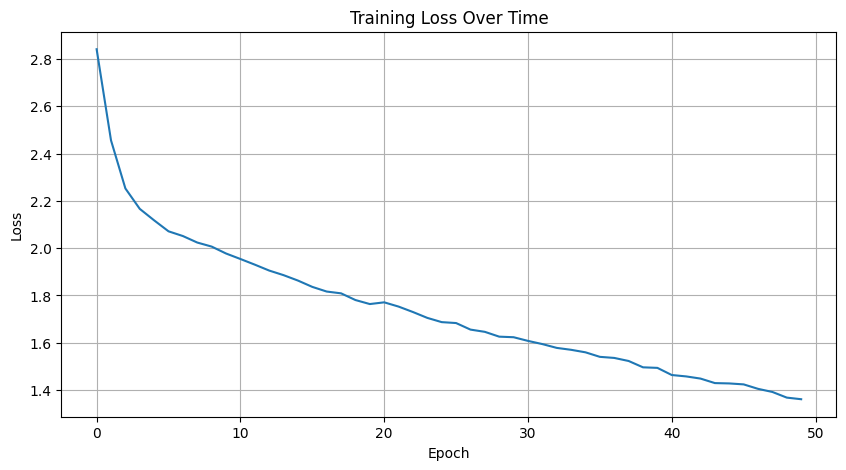

Final loss: 1.3608
✅ Training curve saved


In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.savefig('training_loss.png')
plt.show()

print(f"Final loss: {losses[-1]:.4f}")
print("✅ Training curve saved")

In [6]:
model.eval()

# Test on validation example
test_input = X_val[0:1]
test_target = y_val[0:1]

with torch.no_grad():
    logits, _ = model(test_input)
    predictions = torch.argmax(logits, dim=-1)

print("Test Results:")
print(f"Input:      {test_input[0]}")
print(f"Predicted:  {predictions[0]}")
print(f"Target:     {test_target[0]}")

# Calculate accuracy
accuracy = (predictions[0] == test_target[0]).float().mean()
print(f"\nAccuracy: {accuracy:.1%}")

if accuracy > 0.5:
    print("✅ Model is learning!")
else:
    print("⚠️ Model needs more training")

Test Results:
Input:      tensor([ 9,  5,  1, 12, 15, 18, 10, 13,  4, 12])
Predicted:  tensor([10,  4,  5,  4, 13,  1,  4,  1, 12,  4])
Target:     tensor([ 5,  1, 12, 15, 18, 10, 13,  4, 12,  9])

Accuracy: 10.0%
⚠️ Model needs more training
